In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Optimisation

The goal is to play around with different optimisation methods. I will try to understand them, code them up from scratch, and try them out on some cool objective functions. If I have time, I will try to use Jax or some other autograd library to do additional implementations of the gradient-based optimisation methods.

## Optimisation Methods

### Steepest Descent / Gradient Descent

Taylor's theorem implies that:
$$f(\theta + \Delta) \simeq f(\theta) + \nabla f(\theta)^{T} \cdot \Delta $$
Which will be minimised in $\Delta$ by setting $\Delta \propto -\nabla f(\theta) $. Using this as our direction for selecting the next $\theta$, one would still need to choose an appropriate step length, telling us how far to go in that direction. First, we consider a fixed step size, giving: $\Delta = \alpha \cdot -\nabla f(\theta), \, \alpha \in \mathbb{R}^{+}$.

In [2]:
# Let's code it!

def GD_method(theta_0,f,grad,alpha,method='Iterations',maxiter=100,epsilon=10e-2):
    
    iter_count = 0
    theta_list = [np.array(theta_0)] #final list to be returned

    while True:

        cur_theta = theta_list[iter_count] # fetch current value
        theta_list.append(cur_theta + alpha * -grad(cur_theta)) # update
        iter_count+=1

        if method == 'Iterations':
            if iter_count>maxiter:

                print('Max number of iterations reached: '+str(maxiter))
                print('Final objective function value '+str(f(theta_list[-1]))+' reached at '+str(theta_list[-1]))
                return theta_list

        if method == 'Epsilon':
            if np.abs(f(cur_theta)-f(theta_list[-1]))<epsilon:
                print('Minimal tolerance reached with number of iterations: '+str(iter_count))
                print('Final objective function value '+str(f(theta_list[-1]))+' reached at '+str(theta_list[-1]))
                return theta_list


### Newton's Method

Same principle as GD: we make use of Taylor's theorem to find the step that will minimise the function. Here, we also use the second order term, getting:

$$ f(\theta + \Delta) \simeq f(\theta) + \nabla f(\theta)^T \cdot \Delta + \frac{1}{2} \Delta^T \cdot \nabla^2 f(\theta) \cdot \Delta $$
This is minimised in terms of $\Delta$ when $\nabla^2 f(\theta)\cdot \Delta = -\nabla f(\theta)$, but only if $\nabla^2f(\theta)$ is positive definite. To circumvent this, we can just add multiples of the identity matrix to it until it becomes p.d. (inflate the diagonal), which as it turns out, makes the search direction correspond better with that of GD.

In [12]:
# coding time

def NM(theta_0,f,grad,hes,maxiter=10):

    # Initialise function value, gradient and Hessian
    current = [f(theta_0),grad(theta_0),hes(theta_0)]
    iter_count = 0

    if len(theta_0)==1: # Univariate case
        while iter_count<maxiter:
            theta_new = current[0]-np.matmul(np.linalg.inv(current[2]),current[1])

    else: #multivariate case
        while iter_count<maxiter:
            while np.all(np.linalg.eigvals(current[2]) > 0):
                current[2]=current[2]+np.eye(len(theta_0))
                print(current)
        

In [7]:
np.linalg.cholesky(np.array([[1,2],[2,2]]))

LinAlgError: Matrix is not positive definite

## Objective Functions

## X^2

Minimal tolerance reached with number of iterations: 10
Final objective function value 7.036874417766373e-07 reached at 0.0008388607999999984


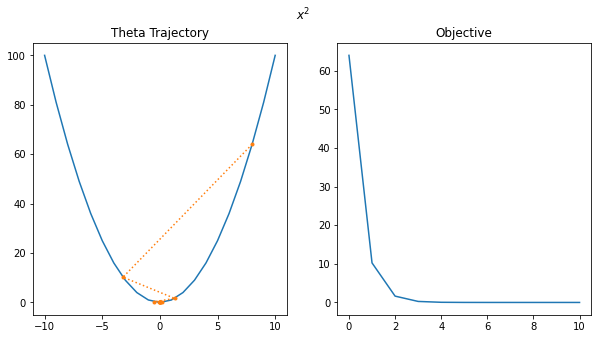

In [10]:
def x2(x):
    return np.power(x,2)
def x2_grad(x):
    return 2*x

def x2_hes(x):
    return 2

theta_vals = GD_method(8,x2,x2_grad,0.7,method='Epsilon',epsilon=10e-6)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('$x^2$')
ax1.plot(range(-10,11),[x2(x) for x in range(-10,11)])
ax1.plot(theta_vals,[x2(i) for i in theta_vals],marker='o',linestyle='dotted',markersize=3)
ax1.set_title('Theta Trajectory')
ax2.plot([x2(x) for x in theta_vals])
ax2.set_title('Objective')
fig.set_size_inches(10,5)
plt.show()

### Rosenbrock function

This is a non-convex function defined by:
$$ f(x,y) = (a-x)^2 +b(y-x^2)^2 $$ 
for $a,b \in \mathbb{R}$. The function always has a global minimum at $(a,a^2)$. Here I take $a=1, b=100$ which seems to be the reference example. 
Then, this function has a gradient of $\nabla f(x,y) = (400x^3-400xy+2x-2,\,200(y-x^2))$.

Max number of iterations reached: 200000
Final objective function value 1.0750282206404076e-08 reached at [0.9998964  0.99979239]


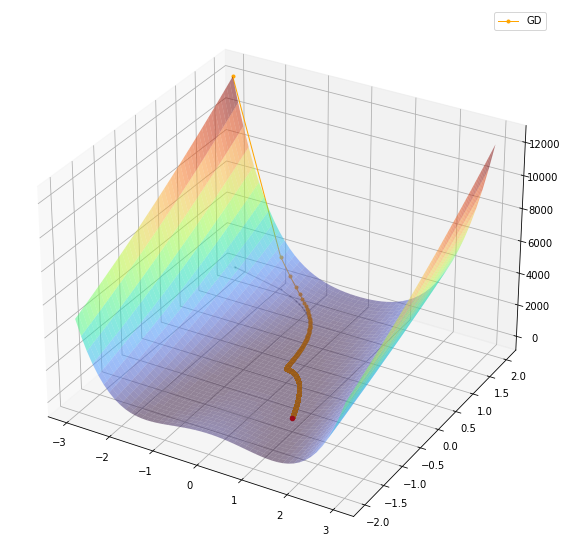

In [4]:
def Ros(theta,a=1,b=100):
    x,y=theta
    return np.power((a-x),2) + b*np.power((y-np.power(x,2)),2)
def Ros_grad(theta):
    x,y=theta
    return np.array([400*np.power(x,3)-400*x*y+2*x-2, 200*(y-np.power(x,2))])

y = np.linspace(-2, 2, 50)
x = np.linspace(-3, 3, 50)
X, Y = np.meshgrid(x, y)
Z = Ros([X, Y])
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(10,10)

ax = plt.axes(projection='3d')
ax.plot_surface(X, -Y, Z, rstride=1, cstride=1,
                cmap='turbo', edgecolor='none',alpha=0.5)

theta_vals = GD_method([-3,-2],Ros,Ros_grad,10e-5,method='Iterations',maxiter=200000)

ax.plot3D([i[0] for i in theta_vals],[-i[1] for i in theta_vals],[0 for i in theta_vals],color='grey',linewidth=1,marker='o',markersize=1,alpha=0.5)
ax.plot3D([i[0] for i in theta_vals],[-i[1] for i in theta_vals],[Ros(i) for i in theta_vals],color='orange',label='GD',linewidth=1,marker='o',markersize=3)
ax.scatter(1,-1,color='red')
plt.legend()
plt.show()